<a href="https://colab.research.google.com/github/SattuSupCodes/SentimentAnalysis_TheoreticalLearning/blob/main/diarisation_gender_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans #from here we start out unsupervised checkpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#CHECKPOINT FOR DENSITY BASED SCAN
import seaborn as sns
import hdbscan
import pandas as pd

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")
# ADDING MORE DATASETS TO ADD DYNAMICS LETS GO
print("Path to dataset files:", path)

100%|██████████| 451M/451M [00:02<00:00, 223MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


# Understanding How Crema-D Dataset Works

eg: 1001_TSI_SAD_XX.wav is actually the format [ActorID]_[Sentence]_[Emotion]_[Intensity].wav
 the CREMA-D is a very good dataset to use to ensure the model does not overfit. (Like what happened with our RAVDESS data here)

 # Gender

 CREMA-D uses actorID metadata to map gender.
 WE MUST USE THIS METADATA ONLY.



In [ ]:
import os
os.listdir(path)


['AudioWAV']

# UHM...
 Nevermind, kaggle seems to have made some tweaks and the gender labels aren't there anymore so...

 # WE SWITCH FROM SUPERVISED -> UNSUPERVISED
 DO I HEAR EXTRA CHALLENGE? LETS GO

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/MyDrive/ravdess')

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24',
 'audio_speech_actors_01-24']

In [ ]:
base_path = "/content/drive/MyDrive/ravdess/audio_speech_actors_01-24"


In [ ]:
# os.listdir(base_path)


In [ ]:
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    return np.concatenate([mfcc_mean, mfcc_std])


In [ ]:
X = []
y = []

for actor in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor)

    if not os.path.isdir(actor_path):
        continue

    actor_id = int(actor.split("_")[1])

    gender_label = 1 if actor_id % 2 == 0 else 0  # 1=female, 0=male

    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            features = extract_mfcc(file_path)

            X.append(features)
            y.append(gender_label)


In [12]:
crema_audio_path = os.path.join(path, "AudioWAV")


# Extracting CREMA-D

using the function extract_mfcc(fp)

In [13]:
X_crema = []
files_crema = []

for file in os.listdir(crema_audio_path):
    if file.endswith(".wav"):
        fp = os.path.join(crema_audio_path, file)
        X_crema.append(extract_mfcc(fp))
        files_crema.append(file)

X_crema = np.array(X_crema)
print("CREMA features:", X_crema.shape)

CREMA features: (7442, 26)


In [14]:
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Male samples:", np.sum(y == 0))
print("Female samples:", np.sum(y == 1))


X shape: (1440, 26)
y shape: (1440,)
Male samples: 720
Female samples: 720


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_crema_scaled = scaler.transform(X_crema)


In [17]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_crema = kmeans.fit_predict(X_crema_scaled)

In [51]:
import numpy as np
unique_labels = np.unique(clusters_crema, return_counts=True)


In [19]:
pitches = []

for file in files_crema:
    y, sr = librosa.load(
        os.path.join(crema_audio_path, file),
        sr=16000
    )
    f0 = librosa.yin(y, fmin=50, fmax=300, sr=sr)
    pitches.append(np.nanmean(f0))

pitches = np.array(pitches)


In [20]:
import pandas as pd

df = pd.DataFrame({
    "cluster": clusters_crema,
    "pitch": pitches
})

df.groupby("cluster")["pitch"].mean()


,pitch
cluster,
0,139.271216
1,148.820513
2,168.761365


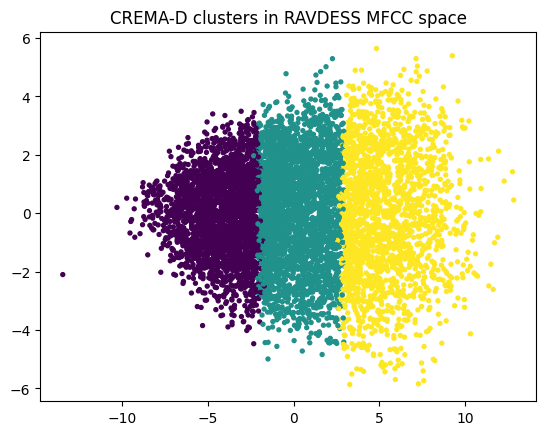

In [21]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_crema_scaled)

plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters_crema, s=8)
plt.title("CREMA-D clusters in RAVDESS MFCC space")
plt.show()

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [26]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(X_test)

HDBSCAN(gen_min_span_tree=True)

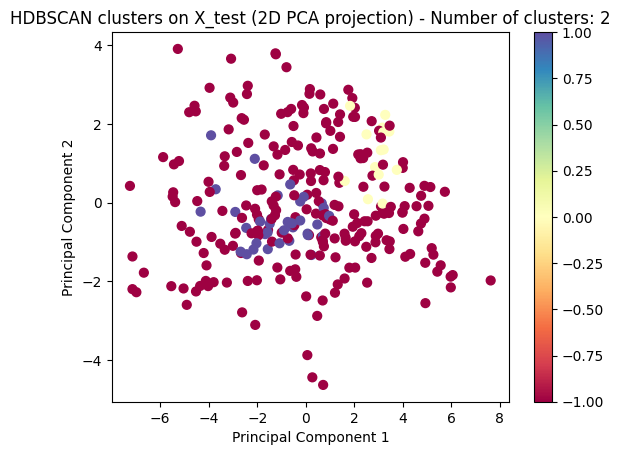

In [42]:
pca_hdbscan = PCA(n_components=2)
X_test_2d_hdbscan = pca_hdbscan.fit_transform(X_test)

# Re-initialize and fit HDBSCAN on X_test to ensure labels correspond to X_test
clusterer_for_plot = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer_for_plot.fit(X_test)
labels = clusterer_for_plot.labels_

# Get the number of clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot the results
plt.scatter(X_test_2d_hdbscan[:, 0], X_test_2d_hdbscan[:, 1], c=labels, cmap='Spectral', s=40)
plt.colorbar()
plt.title(f'HDBSCAN clusters on X_test (2D PCA projection) - Number of clusters: {n_clusters}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [47]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,     # start here
    min_samples=4,
    metric='euclidean'
)

clusters_hdb = clusterer.fit_predict(X_crema_scaled)


In [48]:
np.unique(clusters_hdb, return_counts=True)

(array([-1,  0,  1]), array([3326,   10, 4106]))

In [49]:
df = pd.DataFrame({
    "cluster": clusters_hdb,
    "pitch": pitches
})

df.groupby("cluster")["pitch"].mean()

,pitch
cluster,
-1,158.417911
0,155.567185
1,144.451555


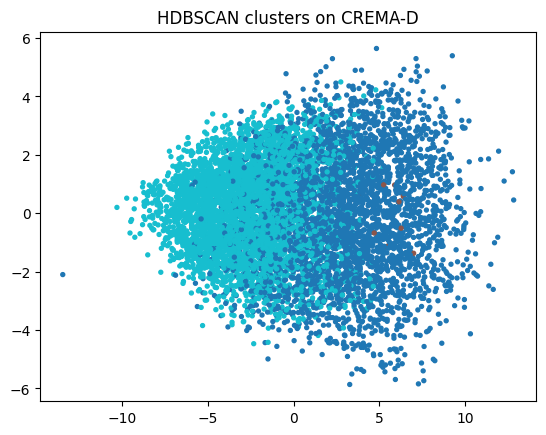

In [50]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_crema_scaled)

plt.scatter(
    X_2d[:,0],
    X_2d[:,1],
    c=clusters_hdb,
    s=8,
    cmap="tab10"
)

plt.title("HDBSCAN clusters on CREMA-D")
plt.show()

In [ ]:
# np.bincount(y)


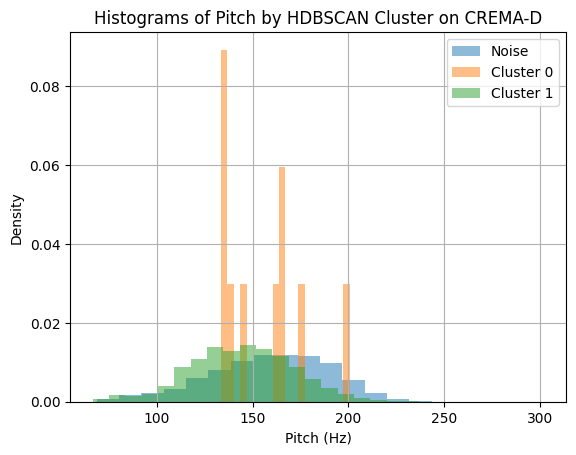

In [53]:
unique_hdb_labels = np.unique(clusters_hdb)

for cluster_id in unique_hdb_labels:
    if cluster_id == -1:
        label_text = 'Noise'
    else:
        label_text = f'Cluster {cluster_id}'

    # Select pitch data points belonging to the current cluster
    cluster_pitch_data = pitches[clusters_hdb == cluster_id]

    # Plot a histogram for this cluster
    # 'alpha' makes the histograms transparent so overlaps are visible
    plt.hist(cluster_pitch_data, bins=20, alpha=0.5, label=label_text, density=True)

plt.title('Histograms of Pitch by HDBSCAN Cluster on CREMA-D')
plt.xlabel('Pitch (Hz)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [54]:
len(pitches) == len(X_crema_scaled)


True

In [55]:
df = pd.DataFrame({
    "cluster": clusters_hdb,
    "pitch": pitches
})

df.groupby("cluster")["pitch"].describe()



,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,3326.0,158.417911,31.457165,68.493135,137.725324,160.816961,181.577825,301.886792
0,10.0,155.567185,21.890827,133.485061,136.598388,153.456867,165.056060,200.731659
1,4106.0,144.451555,26.979208,66.424737,126.124343,144.675727,163.050615,237.132363


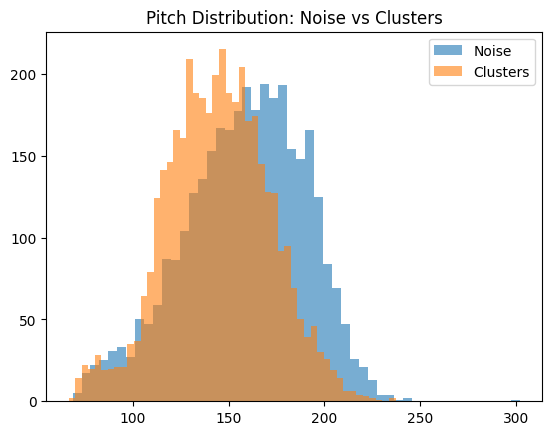

In [56]:
plt.hist(df[df["cluster"] == -1]["pitch"], bins=50, alpha=0.6, label="Noise")
plt.hist(df[df["cluster"] != -1]["pitch"], bins=50, alpha=0.6, label="Clusters")
plt.legend()
plt.title("Pitch Distribution: Noise vs Clusters")
plt.show()


In [58]:


def extract_pitch_frames(y, sr, fmin=50, fmax=400):
    pitch = librosa.yin(
        y,
        fmin=fmin,
        fmax=fmax,
        sr=sr
    )
    pitch = pitch[~np.isnan(pitch)]
    return pitch


In [59]:
pitch_frames = []

for file in audio_files:
    y, sr = librosa.load(file, sr=None)
    pitch_frames.append(extract_pitch_frames(y, sr))


NameError: name 'audio_files' is not defined

# Too Accurate?
don't get happy, our dataset is too good. That's it. (sorry for bursting our bubble) [CHECKPOINT WHRE WE USED ONLY RAVDESS]